<a href="https://colab.research.google.com/github/ESGcompetition/network-analysis/blob/choiyebin/%EA%B3%B5%EB%AA%A8%EC%A0%84_%ED%94%BC%EC%B2%98%EB%B6%84%EC%84%9D_%EC%A4%91%EA%B0%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import & 데이터

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [490]:
import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import re
import math
import requests, json
import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [141]:
YEAR_LIST = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
def jsonToDataFrame(YEAR_LIST):
    temp = {}
    year_list = []
    name = []
    birth = []
    registered = []
    fullTime = []
    responsibilities = []
    career = []
    stock = []
    time1 = []
    time2 = []
    position = []

    for year in YEAR_LIST:
        with open(f"/content/drive/MyDrive/Colab Notebooks/공모전/data/{year}.json", 'r') as f:
            json_data = json.load(f)
            for i in range(len(json_data['results'])):
                properties = json_data['results'][i]['properties']
                year_list.append(year)
                for key in properties:
                    if key == '이름':
                        name.append(properties[key]['title'][0]['text']['content'])
                    elif key == '출생년월':
                        birth.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '등기임원 여부':
                        registered.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '상근 여부':
                        fullTime.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '담당업무':
                        responsibilities.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '주요경력':
                        career.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '의결권 있는 주식수':
                        stock.append(properties[key]['number'])
                    elif key == '재직기간':
                        time1.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '임기만료일':
                        time2.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '직위':
                        position.append(properties[key]['rich_text'][0]['text']['content'])

    temp['이름'] = name
    temp['연도'] = year_list
    temp['출생년월'] = birth
    temp['등기임원 여부'] = registered
    temp['상근 여부'] = fullTime
    temp['담당업무'] = responsibilities
    temp['주요경력'] = career
    temp['의결권 있는 주식수'] = stock
    temp['재직기간'] = time1
    temp['임기만료일'] = time2
    temp['직위'] = position
    return temp

dict = jsonToDataFrame(YEAR_LIST)

df = pd.DataFrame.from_dict(data=dict, orient='columns')

In [142]:
df['의결권 있는 주식수'].fillna(0.0, inplace=True)
#'\xa0' 처리
df['주요경력']=df['주요경력'].str.replace('\xa0', '')
#대학, 전공 피처 생성
temp=df['주요경력'].str.split('\n')
colleges=temp.str.get(0)

#추가로 처리해줘야될 대학 form 맞춰주기
colleges[colleges== 'University of Bath 사회과학대학원(석사)'] ='UniversityofBath 사회과학대학원(석사)'
colleges[colleges== 'Florida International University 경영대학원(박사)']='FloridaInternationalUniversity 경영대학원(박사)'
colleges[colleges== 'Ohio State University 정책대학원(박사)'] = 'OhioStateUniversity 정책대학원(박사)'
colleges[colleges== 'KDI국제정책대학원(석사)'] = 'KDI 국제정책대학원(석사)'
colleges[colleges== '상명여자사범대'] = '상명여자사범대 교육학'
colleges[colleges== '한국외국어대경영학(석사)'] = '한국외국어대 경영학(석사)'
colleges[colleges== '미시간대학교 경영대학원 MBA'] = '미시간대학교 경영대학원MBA'

#대학, 전공으로 나누기
ttemp = colleges.str.split()

#대학 피처 생성
df['대학교']=ttemp.str.get(0)

#전공 피처 생성
tttemp = ttemp.str.get(1)
tttemp=tttemp.replace(r'\([^)]*\)', '', regex=True)
df['전공']=tttemp

#근속연수 생성
def create_work_years(x):
  temp = re.split(r'~|~\n', x)
  temp[0] = temp[0].strip()
  temp[1] = temp[1].strip()
  return int(temp[1][:4]) - int(temp[0][:4])

df['근속연수'] = df['재직기간'].apply(lambda x : create_work_years(x))

#주요경력 전처리
def replace_career(x):
  temp = [string.split() for string in re.split(r'\n |\n', x)]
  if len(temp)==1 :
    return {'대신증권'}
  else:
    return set(list(zip(*temp[1:]))[0])

df['주요경력요약'] = df['주요경력'].apply(lambda x : replace_career(x))

In [143]:
df_2014 = df[df['연도']==2014].reset_index(drop=True)
df_2015 = df[df['연도']==2015].reset_index(drop=True)
df_2016 = df[df['연도']==2016].reset_index(drop=True)
df_2017 = df[df['연도']==2017].reset_index(drop=True)
df_2018 = df[df['연도']==2018].reset_index(drop=True)
df_2019 = df[df['연도']==2019].reset_index(drop=True)
df_2020 = df[df['연도']==2020].reset_index(drop=True)
df_2021 = df[df['연도']==2021].reset_index(drop=True)
df_2022 = df[df['연도']==2022].reset_index(drop=True)
df_2023 = df[df['연도']==2023].reset_index(drop=True)

# 데이터 분석

In [88]:
df

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위,대학교,전공,근속연수,주요경력요약
0,이현식,2014,1962.05,미등기임원,상근,강북지역본부장,서울대 경영학(석사)\n대신증권 시흥동지점장\n대신증권 명일동지점장\n대신증권 퇴직...,4720.0,2012.04.01~2014.12.31,2015.03.20,전무,서울대,경영학,2,{대신증권}
1,조윤남,2014,1968.11,미등기임원,상근,리서치센터장,한국과학기술원 화학공학(석사)\n대신증권 투자전략부장,17401.0,2011.04.01~2014.12.31,2015.03.20,상무,한국과학기술원,화학공학,3,{대신증권}
2,나재철,2014,1960.01,등기임원,상근,업무총괄,한국외국어대 경영학(석사)\n대신증권 강남지역본부장\n대신증권 WM추진본부장\n대신...,23301.0,2004.04.01~2014.12.31,2016.03.31,대표이사,한국외국어대,경영학,10,"{기업금융사업단장, 대신증권, 기획본부장대신증권}"
3,이정훈,2014,1947.06,등기임원,비상근,-,서울대 법학(석사)\n대한중재인협회 회장\n법무법인 태평양 대표변호사(현),0.0,2010.05.28~2014.12.31,2015.03.20,사외이사,서울대,법학,4,"{법무법인, 대한중재인협회}"
4,송혁,2014,1964.04,미등기임원,상근,비서/브랜드담당,전북대 회계학\n대신증권 인수공모2부\n대신증권 비서실장,10391.0,2010.04.01~2014.12.31,2015.03.20,전무,전북대,회계학,4,{대신증권}
5,하창룡,2014,1962.05,미등기임원,상근,강남지역본부장,성균관대 불어불문학\n대신증권 대치동지점 이사대우지점장\n대신증권 남대문지점 이사대...,8331.0,2013.04.01~2014.12.31,2015.03.20,상무,성균관대,불어불문학,1,"{대신증권중부지역본부장, 대신증권}"
6,이동훈,2014,1972.03,미등기임원,상근,Trading Center장,조지아공대 항공우주학(박사)\n대신증권 파생상품운용부 부장\n대신증권 자산운용본부 ...,66237.0,2014.01.01~2014.12.31,2015.03.20,상무,조지아공대,항공우주학,0,{대신증권}
7,박동현,2014,1963.06,미등기임원,상근,서부지역본부장,고려대 법학\n대신증권 화정동지점장\n대신증권 상무지점장\n대신증권 무등지점 이사대...,6736.0,2013.04.01~2014.12.31,2015.03.20,상무,고려대,법학,1,{대신증권}
8,홍대한,2014,1963.05,미등기임원,상근,인재역량센터장,서강대 경제학\n대신증권 영업기획부 부장\n대신증권 기획실 실장\n대신증권 인재전략...,12776.0,2014.01.01~2014.12.31,2015.03.20,상무,서강대,경제학,0,{대신증권}
9,박찬수,2014,1955.07,등기임원,비상근,-,고려대 경영대학원(석사)\n금융감독원 부원장보\nLIG손해보험 상근감사위원\n하비스...,0.0,2013.06.07~2014.12.31,2015.03.20,사외이사,고려대,경영대학원,1,"{하비스트, LIG손해보험, 금융감독원}"


In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   이름          354 non-null    object 
 1   연도          354 non-null    int64  
 2   출생년월        354 non-null    object 
 3   등기임원 여부     354 non-null    object 
 4   상근 여부       354 non-null    object 
 5   담당업무        354 non-null    object 
 6   주요경력        354 non-null    object 
 7   의결권 있는 주식수  354 non-null    float64
 8   재직기간        354 non-null    object 
 9   임기만료일       354 non-null    object 
 10  직위          354 non-null    object 
 11  대학교         354 non-null    object 
 12  전공          354 non-null    object 
 13  근속연수        354 non-null    int64  
 14  주요경력요약      354 non-null    object 
dtypes: float64(1), int64(2), object(12)
memory usage: 41.6+ KB


총 data 354개, //숫자형은 연도, 의결권 있는 주식수, 근속연수

In [145]:
print("2014년 총 임원 수: ", len(df_2014))
print("2015년 총 임원 수: ", len(df_2015))
print("2016년 총 임원 수: ", len(df_2016))
print("2017년 총 임원 수: ", len(df_2017))
print("2018년 총 임원 수: ", len(df_2018))
print("2019년 총 임원 수: ", len(df_2019))
print("2020년 총 임원 수: ", len(df_2020))
print("2021년 총 임원 수: ", len(df_2021))
print("2022년 총 임원 수: ", len(df_2022))
print("2023년 총 임원 수: ", len(df_2022))

2014년 총 임원 수:  30
2015년 총 임원 수:  31
2016년 총 임원 수:  35
2017년 총 임원 수:  32
2018년 총 임원 수:  33
2019년 총 임원 수:  37
2020년 총 임원 수:  36
2021년 총 임원 수:  38
2022년 총 임원 수:  42
2023년 총 임원 수:  42


In [91]:
#2014년도 요약통계
df_2014.describe()

,연도,의결권 있는 주식수,근속연수
count,30.0,3.000000e+01,30.000000
mean,2014.0,1.491268e+05,3.266667
std,0.0,6.261899e+05,2.815393
min,2014.0,0.000000e+00,0.000000
25%,2014.0,1.862500e+03,1.000000
50%,2014.0,8.360000e+03,3.000000
75%,2014.0,1.644950e+04,4.000000
max,2014.0,3.383966e+06,10.000000


In [92]:
#2015년도 요약통계
df_2015.describe()

,연도,의결권 있는 주식수,근속연수
count,31.0,3.100000e+01,31.000000
mean,2015.0,1.530089e+05,3.161290
std,0.0,6.401975e+05,3.142152
min,2015.0,0.000000e+00,0.000000
25%,2015.0,0.000000e+00,1.000000
50%,2015.0,6.846000e+03,2.000000
75%,2015.0,1.338450e+04,4.000000
max,2015.0,3.512510e+06,11.000000


In [93]:
#2016년도 요약통계
df_2016.describe()

,연도,의결권 있는 주식수,근속연수
count,35.0,3.500000e+01,35.000000
mean,2016.0,1.396130e+05,2.771429
std,0.0,6.136473e+05,3.326239
min,2016.0,0.000000e+00,0.000000
25%,2016.0,0.000000e+00,0.000000
50%,2016.0,4.223000e+03,2.000000
75%,2016.0,1.114650e+04,3.500000
max,2016.0,3.562689e+06,12.000000


In [94]:
#2017년도 요약통계
df_2017.describe()

,연도,의결권 있는 주식수,근속연수
count,32.0,32.0,32.000000
mean,2017.0,0.0,3.656250
std,0.0,0.0,3.278566
min,2017.0,0.0,1.000000
25%,2017.0,0.0,1.000000
50%,2017.0,0.0,2.500000
75%,2017.0,0.0,4.250000
max,2017.0,0.0,13.000000


In [95]:
#2018년도 요약통계
df_2018.describe()

,연도,의결권 있는 주식수,근속연수
count,33.0,3.300000e+01,33.000000
mean,2018.0,1.573208e+05,3.121212
std,0.0,6.794034e+05,3.814099
min,2018.0,0.000000e+00,0.000000
25%,2018.0,0.000000e+00,0.000000
50%,2018.0,2.160000e+02,2.000000
75%,2018.0,3.742000e+03,4.000000
max,2018.0,3.814174e+06,14.000000


In [96]:
#2019년도 요약통계
df_2019.describe()

,연도,의결권 있는 주식수,근속연수
count,37.0,3.700000e+01,37.000000
mean,2019.0,1.475846e+05,3.351351
std,0.0,6.702207e+05,3.994553
min,2019.0,0.000000e+00,0.000000
25%,2019.0,0.000000e+00,1.000000
50%,2019.0,6.760000e+02,3.000000
75%,2019.0,3.792000e+03,5.000000
max,2019.0,3.976804e+06,15.000000


In [97]:
#2020년도 요약통계
df_2020.describe()

,연도,의결권 있는 주식수,근속연수
count,36.0,3.600000e+01,36.000000
mean,2020.0,1.632011e+05,2.888889
std,0.0,7.842545e+05,3.662768
min,2020.0,0.000000e+00,0.000000
25%,2020.0,1.077500e+02,1.000000
50%,2020.0,1.360500e+03,2.000000
75%,2020.0,2.938000e+03,4.000000
max,2020.0,4.610498e+06,16.000000


In [98]:
#2021년도 요약통계
df_2021.describe()

,연도,의결권 있는 주식수,근속연수
count,38.0,3.800000e+01,38.000000
mean,2021.0,1.703794e+05,2.973684
std,0.0,8.253398e+05,3.716194
min,2021.0,0.000000e+00,0.000000
25%,2021.0,5.002500e+02,1.000000
50%,2021.0,3.821500e+03,2.000000
75%,2021.0,7.453500e+03,3.000000
max,2021.0,4.985667e+06,17.000000


In [99]:
#2022년도 요약통계
df_2022.describe()

,연도,의결권 있는 주식수,근속연수
count,42.0,4.200000e+01,42.000000
mean,2022.0,1.653508e+05,3.119048
std,0.0,8.156864e+05,3.839476
min,2022.0,0.000000e+00,0.000000
25%,2022.0,7.500000e-01,1.000000
50%,2022.0,3.945500e+03,2.000000
75%,2022.0,1.028200e+04,4.000000
max,2022.0,5.175034e+06,18.000000


In [100]:
#2023년도 요약통계
df_2023.describe()

,연도,의결권 있는 주식수,근속연수
count,40.0,4.000000e+01,40.000000
mean,2023.0,1.742295e+05,3.625000
std,0.0,8.353666e+05,4.029936
min,2023.0,0.000000e+00,0.000000
25%,2023.0,1.515000e+02,1.000000
50%,2023.0,4.810000e+03,3.000000
75%,2023.0,1.228350e+04,4.250000
max,2023.0,5.175034e+06,19.000000


In [146]:
#임원 이름 중복없이 추출
names= []
for i in range(len(df)):
  names.append(df.loc[i, '이름'])
#print(len(names))

names = set(names)

print(len(names))

92


총 임원 92명(중복x)

In [159]:
b=[1, 2]
b.pop(-1)
print(b, len(b))

[1] 1


In [233]:
df_a = df.copy()
for name in names:
  indexes = list(df[df['이름']==name].index)
  indexes.pop(-1) #가장 최신꺼 제외
  if len(indexes) > 0 :
    df_a.drop(indexes, inplace=True) #최신꺼만 남기고 삭제
df_a.reset_index(drop=True, inplace=True)

In [173]:
df_a

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위,대학교,전공,근속연수,주요경력요약
0,구희진,2014,1965.04,미등기임원,상근,Wholesale사업단장,한국외국어대 무역학(석사)\n우리투자증권 기업분석팀장\n대신증권 리서치센터장\n대신...,20357.0,2007.05.02~2014.12.31,2015.03.20,전무,한국외국어대,무역학,7,"{우리투자증권, 대신증권}"
1,임홍재,2014,1959.07,미등기임원,상근,IB사업단장,서울대 경영학(석사)\nIBK투자증권 IB사업부 부사장\n대신증권 IB본부장\n대신...,4491.0,2009.04.01~2014.12.31,2015.03.20,전무,서울대,경영학,5,"{IBK투자증권, 대신증권}"
2,김봉규,2014,1964.04,미등기임원,상근,울산지점장,울산대 경영학\n대신증권 울산남지점장\n대신증권무거동지점장\n대신증권 울산지점 이사...,7673.0,2013.04.01~2014.12.31,2015.03.20,상무보,울산대,경영학,1,"{대신증권무거동지점장, 대신증권}"
3,박찬욱,2014,1949.08,등기임원,비상근,-,명지대 경영학\n서울지방국세청장\n재단법인 정평장학회 이사장\n피앤비세무컨설팅 대표(현),0.0,2010.05.28~2014.12.31,2015.03.20,사외이사,명지대,경영학,4,"{피앤비세무컨설팅, 재단법인, 서울지방국세청장}"
4,김송규,2015,1964.08,미등기임원,상근,인프라관리본부장,대전대 경영학(박사)\n대신증권 관재팀장\n대신증권 총무부장,12434.0,2011.04.01~2015.12.31,2016.03.18,전무,대전대,경영학,4,{대신증권}
5,조윤남,2015,1968.11,미등기임원,상근,리서치센터장,한국과학기술원 화학공학(석사)\n굿모닝신한증권 기업분석부 연구원\n대신증권 투자전략부장,27320.0,2011.04.01~2015.12.31,2016.03.18,전무,한국과학기술원,화학공학,4,"{대신증권, 굿모닝신한증권}"
6,이현식,2015,1962.05,미등기임원,상근,강북지역본부장,서울대 경영학(석사)\n대신증권 시흥동지점장\n대신증권 명일동지점장\n대신증권 퇴직...,4830.0,2012.04.01~2015.12.31,2016.03.18,전무,서울대,경영학,3,{대신증권}
7,장광수,2015,1962.09,미등기임원,상근,금융주치의사업단장,한양대 경영학\n대신증권 정자동지점장\n대신증권 송탄지점장\n대신증권 중부지역본부장...,4497.0,2012.04.01~2015.12.31,2016.03.18,전무,한양대,경영학,3,{대신증권}
8,이인형,2015,1964.02,등기임원,비상근,-,Brown대 경제학(박사)\nLG경제연구원 금융연구실 실장\n수원대 경영학부 교수\...,0.0,2011.05.27~2015.12.31,2016.03.18,사외이사,Brown대,경제학,4,"{LG경제연구원, KAIST, 수원대, 자본시장연구원}"
9,김경찬,2016,1964.06,미등기임원,상근,-,연세대 정치학(석사)\n한국투자증권 온라인사업추진단 부장\n한국투자증권평촌지점 상무...,0.0,2014.01.16~2016.12.31,2017.03.24,상무,연세대,정치학,2,"{대신증권, 한국투자증권평촌지점, 부영주택, 한국투자증권}"


## <중복없이 임원들에 대해서 피처 살펴보기>

## 대학

In [234]:
## 중복 통합
df_a.loc[df_a['대학교']=='연세대학교', '대학교'] = '연세대'
df_a.loc[df_a['대학교']=='성균관대학교', '대학교'] = '성균관대'
df_a.loc[df_a['대학교']=='한국외국어대', '대학교'] = '한국외대'
df_a.loc[df_a['대학교']=='세종대학교', '대학교'] = '세종대'
df_a.loc[df_a['대학교']=='가천대학교', '대학교'] = '가천대'
df_a.loc[df_a['대학교']=='충북대학교', '대학교'] = '충북대'

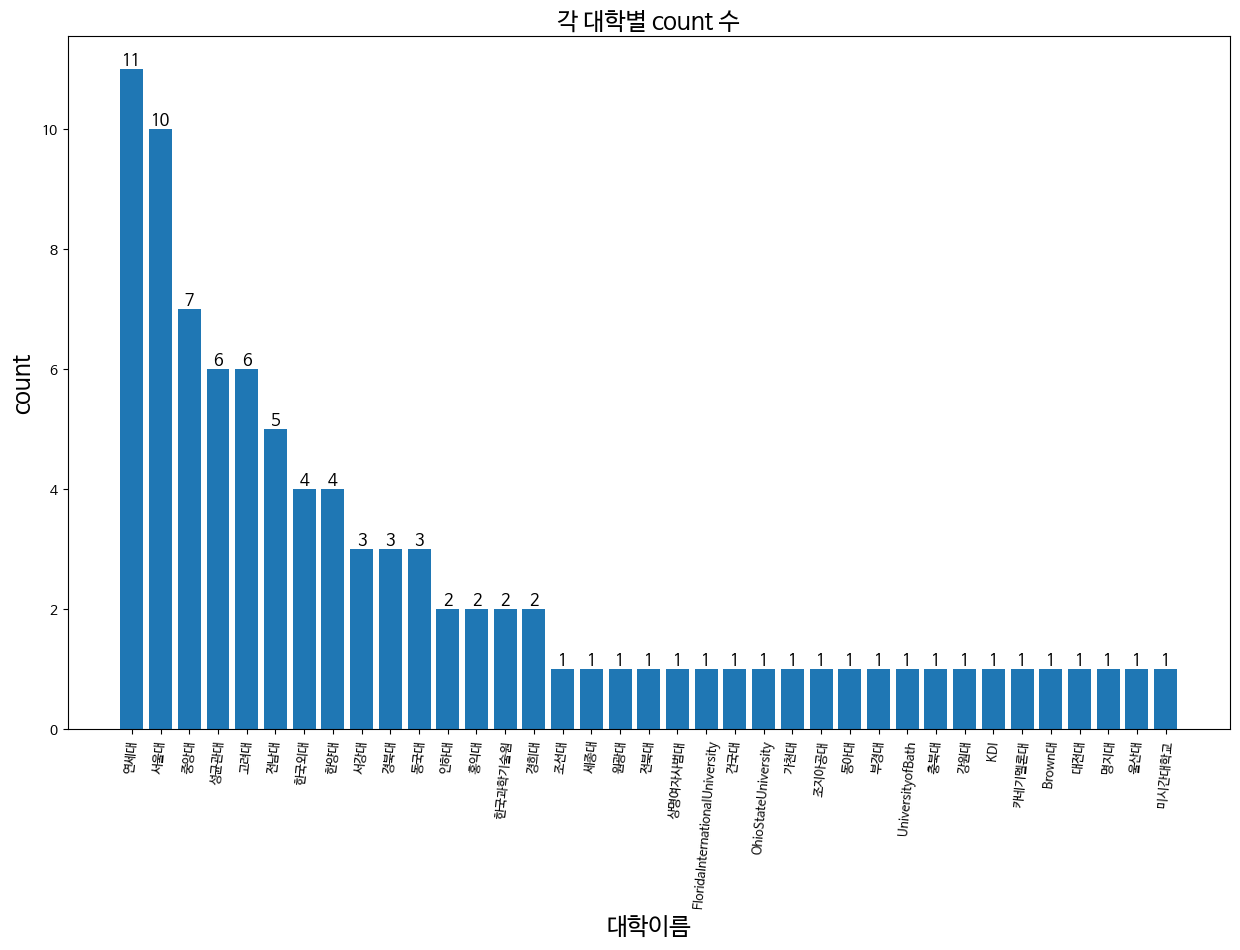

In [401]:
#각 대학별 count 막대그래프
x = df_a['대학교'].value_counts().index
y = df_a['대학교'].value_counts().values
plt.figure(figsize=(15,9))
plt.xticks(rotation=85, size= 9)
plt.xlabel('대학이름', size=17)
plt.ylabel('count', size=17)
plt.title('각 대학별 count 수', size=17)
bar = plt.bar(x, y)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.f' % height, ha='center', va='bottom', size = 12)

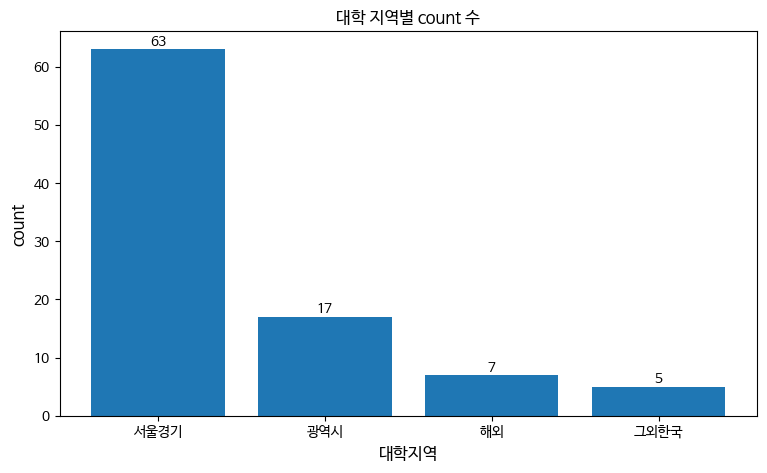

In [301]:
# 대학 지역별 count 막대그래프
def find_college_location(x):
  #지역별로 대학 딕셔너리
  college_dict = {'서울경기':['상명여자사범대', '서울대', '홍익대', '성균관대', '연세대', '연세대학교', '동국대', '중앙대', '한국외대', '한국외국어대', '세종대학교', '세종대', '성균관대학교', '경희대', '서강대', '고려대', '건국대', '가천대', '가천대학교', '한양대', '명지대'],
                   '광역시':['부경대', '경북대', '전남대', '조선대', '한국과학기술원', '가천대', '인하대', '동아대', '대전대', '울산대', '영남공업전문대'],
                   '그외한국':['전북대', '원광대', '충북대', '충북대학교', '강원대', 'KDI'],
                   '해외':['FloridaInternationalUniversity', 'OhioStateUniversity', 'UniversityofBath', '조지아공대', 'Brown대', '카네기멜론대', '미시간대학교']}

  #키값 찾기
  for key, val in college_dict.items() :
    if x in val :
      return key


df_a['지역별 대학'] = df_a['대학교'].apply(find_college_location)

#그래프
x = df_a['지역별 대학'].value_counts().index
y = df_a['지역별 대학'].value_counts().values
plt.rc('font', family='NanumBarunGothic')
plt.figure(figsize=(9,5))
plt.xlabel('대학지역', size=12)
plt.ylabel('count', size=12)
plt.title('대학 지역별 count 수', size=12)
bar = plt.bar(x, y)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.f' % height, ha='center', va='bottom', size = 10)

## 전공

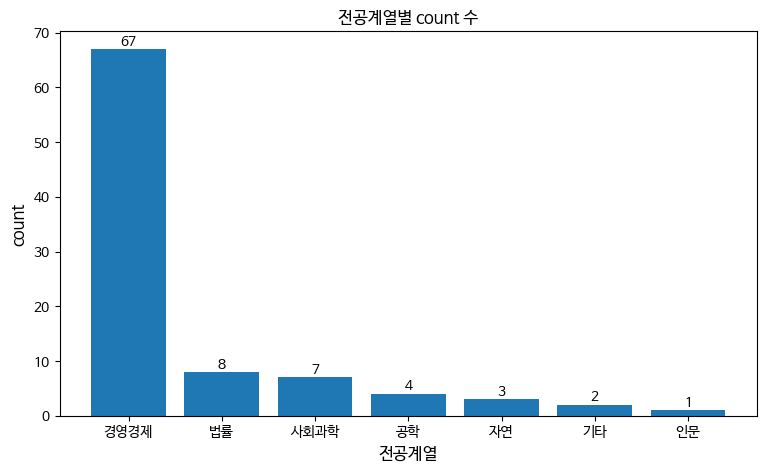

In [341]:
# 전공 계열별 count 막대그래프
def find_department_location(x):
  #전공별 계열 딕셔너리
  department_dict={'경영경제':['회계학', '세무학', '경제학', '국제경영학', '경영학', '무역학', 'MBA', '경제통상학', '경영대학원', '경영대학원MBA', '산업정보학', '금융공학', '국제금융학'],
                   '사회과학':['사회학', '사회과학대학원', '행정학', '정치외교학', '정치학', '신문방송학'],
                   '법률':['법학', '사법학', '정책대학원', '국제정책대학원'],
                   '인문':['불어불문학'],
                   '기타':['교육학', '인적자원개발학'],
                   '자연':['응용통계학', '통계학', '수학'],
                   '공학':['기계공학', '화학공학', '전자계산학', '전자전산학', '전산학', '항공우주학']}

  #키값 찾기
  for key, val in department_dict.items() :
    if x in val :
      return key

df_a['전공계열'] = df_a['전공'].apply(find_department_location)

#그래프
x = df_a['전공계열'].value_counts().index
y = df_a['전공계열'].value_counts().values
plt.rc('font', family='NanumBarunGothic')
plt.figure(figsize=(9,5))
plt.xlabel('전공계열', size=12)
plt.ylabel('count', size=12)
plt.title('전공계열별 count 수', size=12)
bar = plt.bar(x, y)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.f' % height, ha='center', va='bottom', size = 10)

## 직위

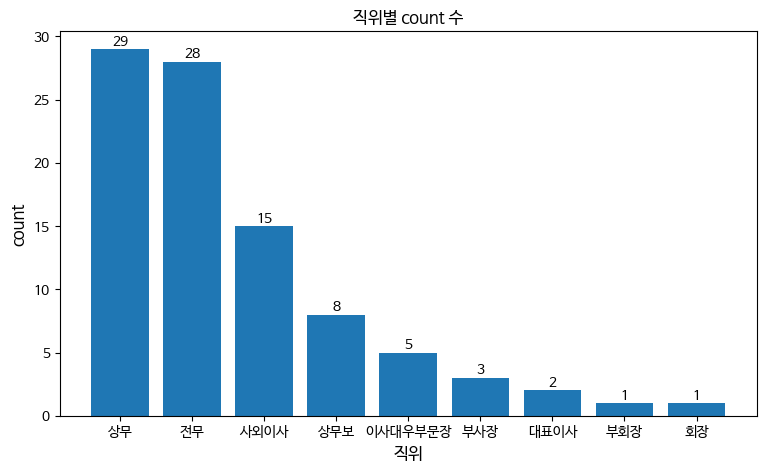

In [340]:
#직위 count 막대그래프
x = df_a['직위'].value_counts().index
y = df_a['직위'].value_counts().values
plt.figure(figsize=(9,5))
plt.xlabel('직위', size=12)
plt.ylabel('count', size=12)
plt.title('직위별 count 수', size=12)
bar = plt.bar(x, y)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.f' % height, ha='center', va='bottom', size = 10)

## 근속연수

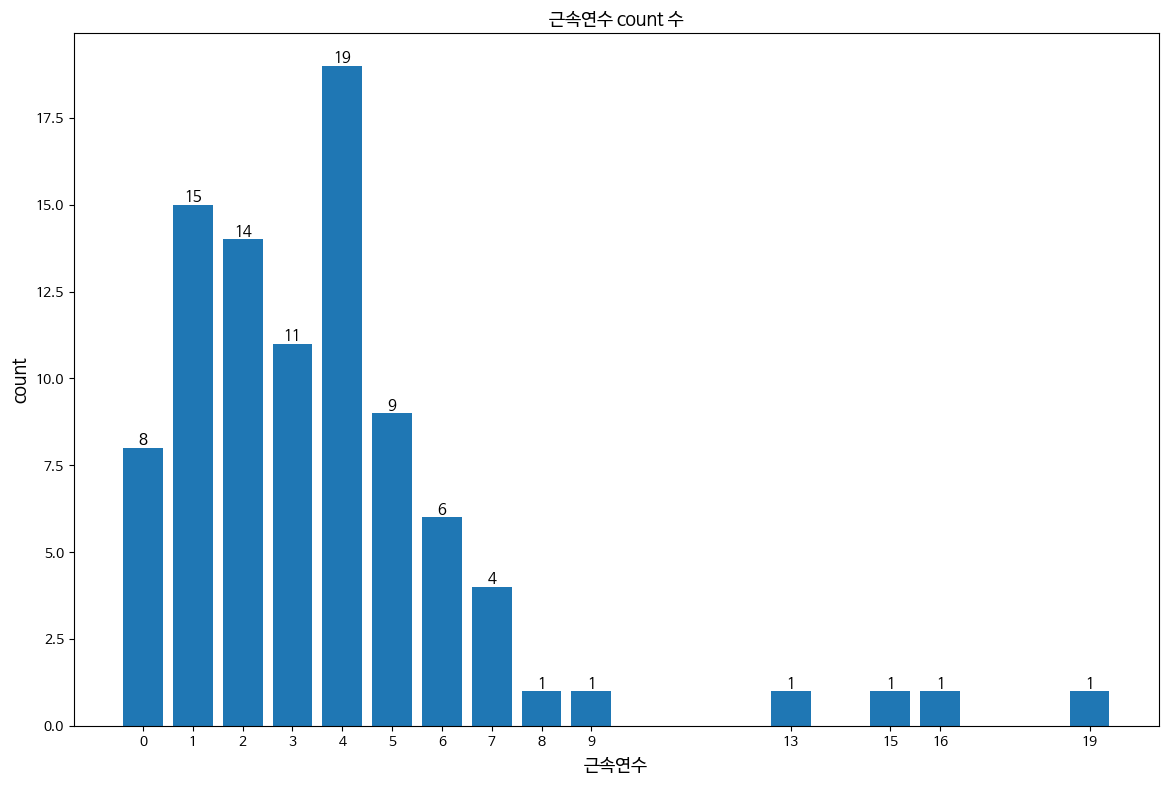

In [339]:
#근속연수 count 막대그래프
x = df_a['근속연수'].value_counts().index
y = df_a['근속연수'].value_counts().values
plt.figure(figsize=(14,9))
plt.xticks(x)
plt.xlabel('근속연수', size=13)
plt.ylabel('count', size=13)
plt.title('근속연수 count 수', size=13)
bar = plt.bar(x, y)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.f' % height, ha='center', va='bottom', size = 11)

Text(0.5, 1.0, '근속연수 boxplot')

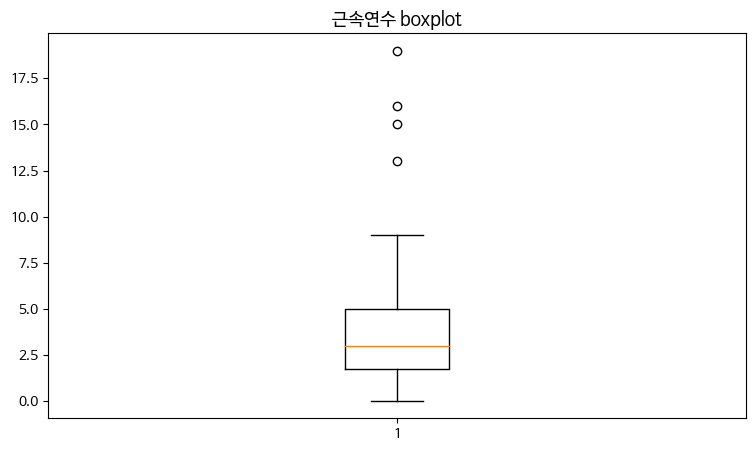

In [312]:
#근속연수 boxplot
plt.figure(figsize=(9,5))
plt.boxplot(df_a['근속연수'])
plt.title('근속연수 boxplot', size=13)

In [309]:
df_a['근속연수'].describe()

count    92.000000
mean      3.706522
std       3.320062
min       0.000000
25%       1.750000
50%       3.000000
75%       5.000000
max      19.000000
Name: 근속연수, dtype: float64

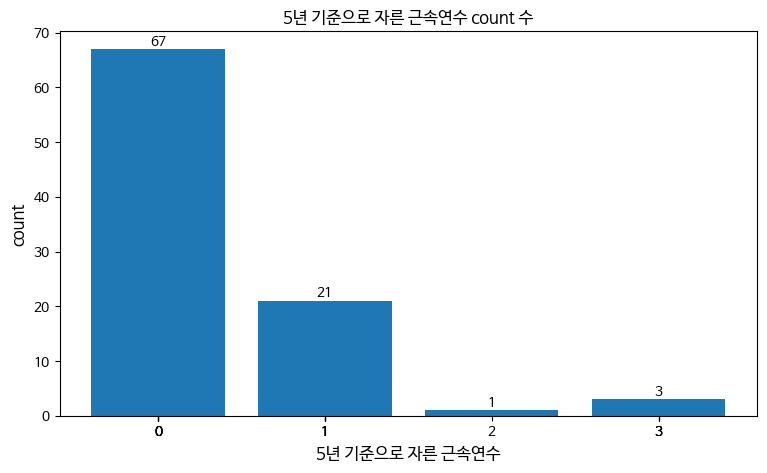

In [338]:
#5년 기준으로 자른 근속연수 count 막대그래프
x = df_a['근속연수'].value_counts().index
y = df_a['근속연수'].value_counts()
xx = list(map(lambda x: x//5, x))
yy = [0 for i in range(4)]
for i in range(len(xx)):
  aa = xx[i]
  yy[xx[i]] += y[x[i]]
plt.figure(figsize=(9,5))
plt.xticks(xx)
plt.xlabel('5년 기준으로 자른 근속연수', size=12)
plt.ylabel('count', size=12)
plt.title('5년 기준으로 자른 근속연수 count 수', size=12)
bar = plt.bar(list(set(xx)), yy)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.f' % height, ha='center', va='bottom', size = 10)

## 담당업무

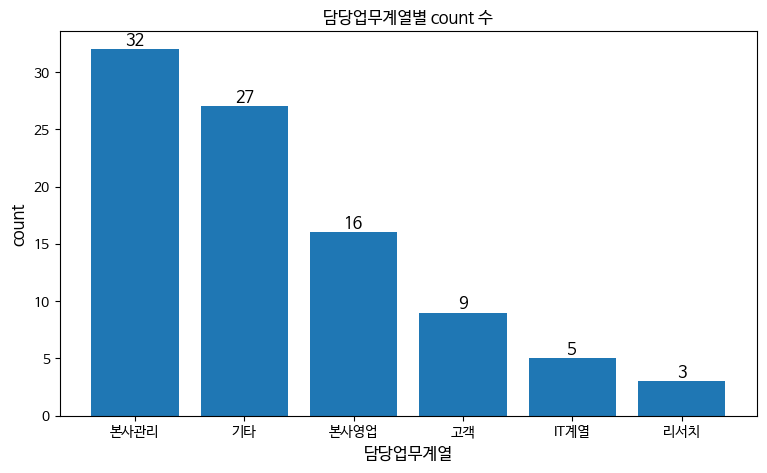

In [324]:
#담당업무 같은 계열 별 count 막대그래프
def find_task_location(x):
  #담당업무 딕셔너리
  task_dict={'IT계열': {'IT':['IT부문장', 'IT본부장', 'IT서비스본부장', '디지털부문장', '스마트Biz본부장', 'Operation&Technology본부장'], '정보보호':['정보보호부문장', '정보보호담당']},
             '본사영업':{'Wolesale':['Wholesale부문장','Wholesale영업본부장', 'Wholesale사업단장', 'Trading부문장', 'Trading Center장', 'Sales&Trading총괄', '대외협력담당'],
                     'IB':['IB사업단장', 'IB부문장', 'IB부부문장', 'IB1부문장', 'IB2부문장', 'IPO담당',  'PF부문장', 'PF1본부장', '구조화상품본부장'],
                     '영업':['영업부장']},
             '본사관리':{'리테일':['리테일총괄', 'Club1962센터장','WM추진부문장', 'WM추진본부장', 'WM사업단장'],
                     '리스크':['리스크관리부문장', '리스크관리담당'] ,
                     '경영':['경영전략총괄', '전략지원부문장', '전략지원담당', '경영지원본부장', '경영지원부문장', '경영기획부문장', '경영기획본부장', '기획본부장', '기획본부장 / 투자금융담당', '전략지원부문장/프라이빗라운지 부문장'],
                     '상품':['Product부문장', 'Solution&Product사업단장'],
                     '업무':['업무총괄',  '업무총괄(IB사업단, 고객자산본부 제외)', '업무총괄(IB사업단,고객자산본부 제외)', '업무총괄 (IB사업단,고객자산본부 제외)', '업무총괄(IB사업단, 고객자산본부, 경영지원본부, 정보보호부문, 준법지원부문, 감사부문 제외)'],
                     '금융':['기업금융담당', '스마트금융본부장', '금융주치의추진본부장', '금융주치의사업단장'],
                     '인사,인프라':['인재역량센터장', '인프라관리본부장'],
                     '법률':['준법감시인\n 준법지원부문장', '준법감시인 준법지원부문장', '준법감시인\n준법지원부문장', '준법감시인\n준법지원담당', '준법감시인/준법지원부문장', '준법감시인 / 준법지원담당', 'Advisory본부장'],
                     '감사':['감사위원장', '감사부문장', '감사위원', '상근감사위원', '감사담당'],
                     '언론홍보':['홍보부문장', 'Coverage본부장']},
             '리서치': {'리서치센터':['Research Center장', '리서치센터장', 'Market\n  Solution부문장', 'Research&Strategy본부장', 'Market Solution부문장', 'Market Solution 부문장']},
             '고객':{'고객자산':['고객자산부문장', '고객자산부문 부부문장', '고객자산본부장', '고객자산본부장 / 홍보담당', '고객자산본부장/ 홍보담당', '고객자산본부장/ 홍보부문장', '고객자산본부장/홍보부문장', '고객자산부문장, 홍보부문장', '고객자산부문장\n홍보부문장'],
                   'WM':['서부WM부문장', '서부WM본부장', '재경1WM부문장', '재경1WM본부장', '재경2WM본부장', '재경2WM부문장', '동부WM부문장', '동부WM본부장'],
                   '프라이빗':['프라이빗부문장,\n 나인원프라이빗라운지장', '프라이빗부문장, 나인원프라이빗라운지장', '대신나인원 \n프라이빗라운지장', '프라이빗라운지 부문장 /대신나인원 프라이빗라운지장', '프라이빗부문장, 대신나인원프라이빗라운지장', '프라이빗부문장\n나인원프라이빗라운지장',],
                   '소비자보호':['금융소비자보호부문장\n(COO)', '금융소비자보호부문장(COO)', '금융소비자보호부문장 (COO)', '금융소비자보호 총괄', '금융소비자보호총괄']},
             '기타':{'지점':['강북지역본부장', '강남지역본부장', '강남선릉센터장', '서부지역본부장', '동부지역본부장', '울산지점장'],
                   '비서':['비서실장', '비서/브랜드본부', '비서/브랜드담당'], '공란':['-']}}

   #키값 찾기
  for outerKey in task_dict.keys() :
    for key, val in task_dict[outerKey].items() :
      if x in val :
        return outerKey

df_a['담당업무계열'] = df_a['담당업무'].apply(find_task_location)

#그래프
x = df_a['담당업무계열'].value_counts().index
y = df_a['담당업무계열'].value_counts().values
plt.rc('font', family='NanumBarunGothic')
plt.figure(figsize=(9,5))
plt.xlabel('담당업무계열', size=12)
plt.ylabel('count', size=12)
plt.title('담당업무계열별 count 수', size=12)
bar = plt.bar(x, y)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.f' % height, ha='center', va='bottom', size = 12)


## 경력

In [386]:
def find_career_location(x):
  # 경력 딕셔너리
  career_dict={1:['대신증권', '대신증권WM사업단장', 'WM추진부문장', '재경1WM부문장', '대신증권중부지역본부장', '기획본부장대신증권', '대신증권분당지점장', '대신증권무거동지점장', '대신증권Capital',
                  '이사대우부본부장', '기획본부장대신증권인재역량센터장', '대신증권인재전략부', '대신증권파생상품운용부장', '대신증권자산운용본부', '대신증권영업기획부장', '대신증권기획실장',
                  '대신증권홍보실', '대신증권브랜드전략실', '대신증권IT개발부장', '대신증권트레이딩시스템부장', '대신증권Global사업본부', '신증권', '기업금융사업단장'], #대신증권
               0:['대신에프앤아이', '대신투자신탁운용', '대신투자신탁운용상무이사', '대신에이엠씨', '대신자산운용', '대신저축은행'], #대신증권 자회사
               2:['메리츠종금증권', '메리츠증권', '미래에셋증권', 'KTB투자증권', 'SC제일은행', '하나금융투자', 'IBK투자증권', 'DB금융투자', 'NH투자증권', 'KB증권', 'LIG손해보험', '굿모닝신한증권', '메릴린치증권',
                  '삼성증권', '동양증권', '한국투자증권', '한국투자증권평촌지점', '대우증권', '대우본부장', '대우증권전략기획본부', '대우증권해외사업부문', '대우증권IB사업부문',
                  '우리투자증권', '우리CS자산운용', '우리투자증권기업금융2팀장', '우리프라이빗에쿼티', '푸르덴셜투자증권', '하이투자증권주식인수팀',  '하이투자증권주식인수팀', 'SBC', 'Bank', '도이치은행'], #타증권사
               3:['금융감독원', '금융위원회', '現)금융위원회', '감사원', '대검찰청', '법무법인', '現)법무법인', '세무법인', '국세청', '중부지방국세청', '서울북부지방검찰청','서울지방국세청장', '서울지방국세청',
                  '제58대', '제22대', '기획재정부', '국세청,관세청,산업통상자원부', '자본시장연구원', '한국조세연구원', '국가청렴위원회', '대한중재인협회', '한국회계정보학회',
                  '금융위원회금융발전심의위원(현)', '금융위원회적극행정심의위원(現)', '안진회계법인',  'L&C세무회계사무소', '변호사정상명법률사무소', '피앤비세무컨설팅', '現)법무법인(유)'], #법,정책
               4:['중앙대', '중앙대학교', '現)중앙대', '연세대학교', 'KAIST', '수원대', '수원대학교', '서울시립대', '現)서울시립대', '학교법인', '現)학교법인', '재단법인', '現)재단법인'], #학교, 교수, 재단
               5:['하비스트', '한국물산', '우리선물', '부영주택', 'LG경제연구원', 'Arthur'] #기타
               }

  #경력 여부 빈리스트 생성
  x_list = [0,0,0,0,0,0] #1번인덱스: 대신증권, 0번인덱스: 대신증권 자회사, 2번인덱스: 타증권사, 3번인덱스: 기타

  #리스트에 각 업종에 종사했었으면 1, 아니면 0
  for career in x :
    for key, val in career_dict.items() :
      if career in val :
        x_list[key]=1
  return x_list

# 리스트의 각 요소에 접근하는 함수
def element_0(lst):
  return lst[0]

def element_1(lst):
  return lst[1]

def element_2(lst):
  return lst[2]

def element_3(lst):
  return lst[3]

def element_4(lst):
  return lst[4]

def element_5(lst):
  return lst[5]

df_a['주요경력리스트'] = df_a['주요경력요약'].apply(find_career_location)

#경력 원핫인코딩
df_a['대신증권자회사종사'] = df_a['주요경력리스트'].apply(lambda x: element_0(x))
df_a['대신증권종사'] = df_a['주요경력리스트'].apply(lambda x: element_1(x))
df_a['타증권사종사'] = df_a['주요경력리스트'].apply(lambda x: element_2(x))
df_a['법정책종사'] = df_a['주요경력리스트'].apply(lambda x: element_3(x))
df_a['학교재단종사'] = df_a['주요경력리스트'].apply(lambda x: element_4(x))
df_a['기타종사'] = df_a['주요경력리스트'].apply(lambda x: element_5(x))

In [387]:
df_a

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,...,지역별 대학,전공계열,담당업무계열,주요경력리스트,대신증권자회사종사,대신증권종사,타증권사종사,법정책종사,학교재단종사,기타종사
0,구희진,2014,1965.04,미등기임원,상근,Wholesale사업단장,한국외국어대 무역학(석사)\n우리투자증권 기업분석팀장\n대신증권 리서치센터장\n대신...,20357.0,2007.05.02~2014.12.31,2015.03.20,...,서울경기,경영경제,본사영업,"[0, 1, 1, 0, 0, 0]",0,1,1,0,0,0
1,임홍재,2014,1959.07,미등기임원,상근,IB사업단장,서울대 경영학(석사)\nIBK투자증권 IB사업부 부사장\n대신증권 IB본부장\n대신...,4491.0,2009.04.01~2014.12.31,2015.03.20,...,서울경기,경영경제,본사영업,"[0, 1, 1, 0, 0, 0]",0,1,1,0,0,0
2,김봉규,2014,1964.04,미등기임원,상근,울산지점장,울산대 경영학\n대신증권 울산남지점장\n대신증권무거동지점장\n대신증권 울산지점 이사...,7673.0,2013.04.01~2014.12.31,2015.03.20,...,광역시,경영경제,기타,"[0, 1, 0, 0, 0, 0]",0,1,0,0,0,0
3,박찬욱,2014,1949.08,등기임원,비상근,-,명지대 경영학\n서울지방국세청장\n재단법인 정평장학회 이사장\n피앤비세무컨설팅 대표(현),0.0,2010.05.28~2014.12.31,2015.03.20,...,서울경기,경영경제,기타,"[0, 0, 0, 1, 1, 0]",0,0,0,1,1,0
4,김송규,2015,1964.08,미등기임원,상근,인프라관리본부장,대전대 경영학(박사)\n대신증권 관재팀장\n대신증권 총무부장,12434.0,2011.04.01~2015.12.31,2016.03.18,...,광역시,경영경제,본사관리,"[0, 1, 0, 0, 0, 0]",0,1,0,0,0,0
5,조윤남,2015,1968.11,미등기임원,상근,리서치센터장,한국과학기술원 화학공학(석사)\n굿모닝신한증권 기업분석부 연구원\n대신증권 투자전략부장,27320.0,2011.04.01~2015.12.31,2016.03.18,...,광역시,공학,리서치,"[0, 1, 1, 0, 0, 0]",0,1,1,0,0,0
6,이현식,2015,1962.05,미등기임원,상근,강북지역본부장,서울대 경영학(석사)\n대신증권 시흥동지점장\n대신증권 명일동지점장\n대신증권 퇴직...,4830.0,2012.04.01~2015.12.31,2016.03.18,...,서울경기,경영경제,기타,"[0, 1, 0, 0, 0, 0]",0,1,0,0,0,0
7,장광수,2015,1962.09,미등기임원,상근,금융주치의사업단장,한양대 경영학\n대신증권 정자동지점장\n대신증권 송탄지점장\n대신증권 중부지역본부장...,4497.0,2012.04.01~2015.12.31,2016.03.18,...,서울경기,경영경제,본사관리,"[0, 1, 0, 0, 0, 0]",0,1,0,0,0,0
8,이인형,2015,1964.02,등기임원,비상근,-,Brown대 경제학(박사)\nLG경제연구원 금융연구실 실장\n수원대 경영학부 교수\...,0.0,2011.05.27~2015.12.31,2016.03.18,...,해외,경영경제,기타,"[0, 0, 0, 1, 1, 1]",0,0,0,1,1,1
9,김경찬,2016,1964.06,미등기임원,상근,-,연세대 정치학(석사)\n한국투자증권 온라인사업추진단 부장\n한국투자증권평촌지점 상무...,0.0,2014.01.16~2016.12.31,2017.03.24,...,서울경기,사회과학,기타,"[0, 1, 1, 0, 0, 1]",0,1,1,0,0,1


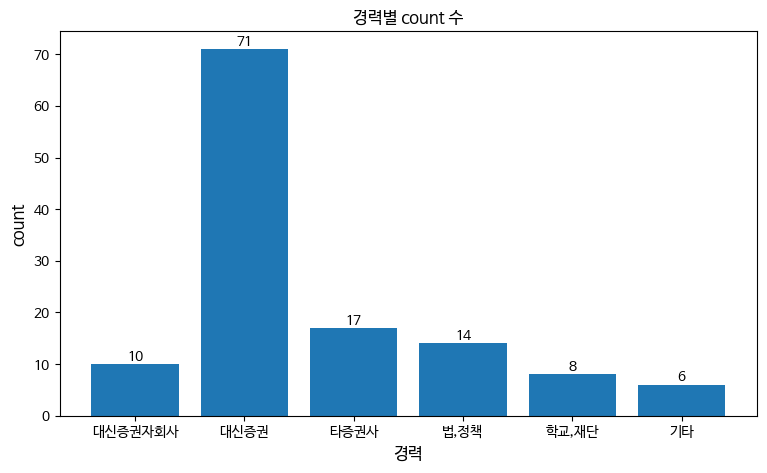

In [389]:
#경력 별 count 막대그래프
x = ['대신증권자회사', '대신증권', '타증권사', '법,정책', '학교,재단', '기타']
y = [df_a['대신증권자회사종사'].sum(), df_a['대신증권종사'].sum(), df_a['타증권사종사'].sum(), df_a['법정책종사'].sum(), df_a['학교재단종사'].sum(), df_a['기타종사'].sum()]
plt.figure(figsize=(9,5))
plt.xlabel('경력', size=12)
plt.ylabel('count', size=12)
plt.title('경력별 count 수', size=12)
bar = plt.bar(x, y)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.f' % height, ha='center', va='bottom', size = 10)

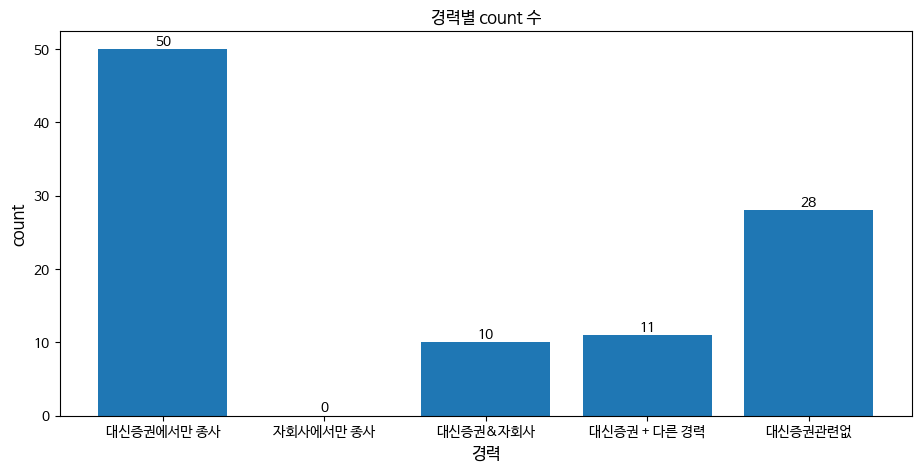

In [400]:
#대신증권 관련 경력더 살펴보기
x = ['대신증권에서만 종사', '자회사에서만 종사', '대신증권&자회사', '대신증권 + 다른 경력', '대신증권관련없']

mother = df_a['주요경력리스트'].apply(lambda x: x==[0,1,0,0,0,0]).sum()
child = df_a['주요경력리스트'].apply(lambda x: x==[1,0,0,0,0,0]).sum()
mother_child = df_a['주요경력리스트'].apply(lambda x: x==[1,1,0,0,0,0]).sum()
other_daesin = df_a['대신증권종사'].sum() - mother - child - mother_child
others = df_a['법정책종사'].sum() + df_a['학교재단종사'].sum() + df_a['기타종사'].sum()

y = [mother, child, mother_child, other_daesin, others]

plt.figure(figsize=(11,5))
plt.xlabel('경력', size=12)
plt.ylabel('count', size=12)
plt.title('경력별 count 수', size=12)
bar = plt.bar(x, y)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.f' % height, ha='center', va='bottom', size = 10)

## 보유주식

Text(0.5, 1.0, '보유주식 boxplot')

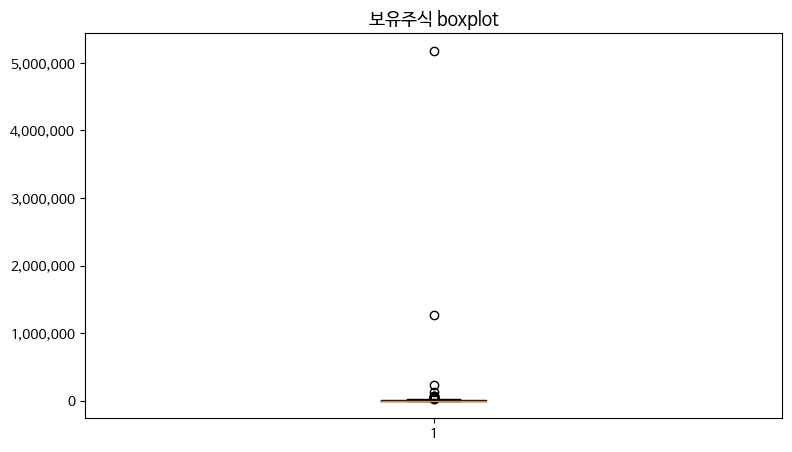

In [333]:
#보유주식 boxplot
plt.figure(figsize=(9,5))
plt.boxplot(df_a['의결권 있는 주식수'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.title('보유주식 boxplot', size=13)

In [334]:
df_a['의결권 있는 주식수'].describe()

count    9.200000e+01
mean     8.187365e+04
std      5.535057e+05
min      0.000000e+00
25%      0.000000e+00
50%      2.432500e+03
75%      9.564500e+03
max      5.175034e+06
Name: 의결권 있는 주식수, dtype: float64

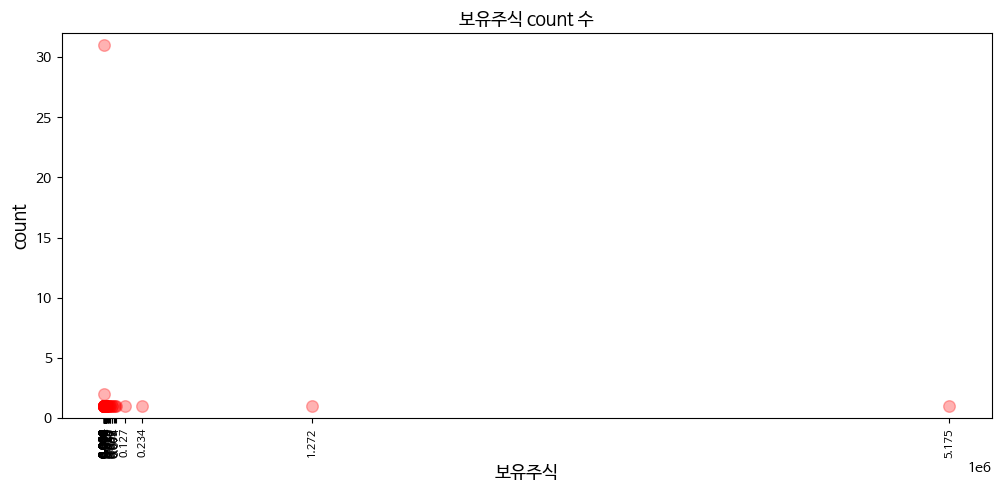

In [369]:
#보유주식 count 산점도그래프
x = df_a['의결권 있는 주식수'].value_counts().index
y = df_a['의결권 있는 주식수'].value_counts().values
plt.figure(figsize=(12,5))
plt.ylim(y.min()-1, y.max()+1)
plt.xticks(x, rotation=90, size=8)
plt.xlabel('보유주식', size=13)
plt.ylabel('count', size=13)
plt.title('보유주식 count 수', size=13)
plt.scatter(x, y, alpha = 0.3, s= 70, color = 'red')

In [374]:
df_a['의결권 있는 주식수'].value_counts()

0.0          31
73.0          2
20357.0       1
2820.0        1
8677.0        1
3594.0        1
11895.0       1
7270.0        1
337.0         1
32531.0       1
4269.0        1
23739.0       1
177.0         1
799.0         1
607.0         1
67341.0       1
39839.0       1
13449.0       1
9932.0        1
6765.0        1
73785.0       1
75.0          1
10363.0       1
2943.0        1
8161.0        1
10531.0       1
1271697.0     1
9269.0        1
3986.0        1
35190.0       1
127345.0      1
5175034.0     1
5351.0        1
234218.0      1
7673.0        1
12434.0       1
27320.0       1
4830.0        1
4497.0        1
64839.0       1
4766.0        1
895.0         1
14014.0       1
992.0         1
111.0         1
52051.0       1
49666.0       1
4491.0        1
1500.0        1
2126.0        1
2673.0        1
12749.0       1
2192.0        1
5034.0        1
1254.0        1
3620.0        1
8285.0        1
9442.0        1
7644.0        1
3524.0        1
1262.0        1
Name: 의결권 있는 주식수, dtype:

In [377]:
#count 최댓값 주식수, count수
print(df_a['의결권 있는 주식수'].value_counts().idxmax(), ',', df_a['의결권 있는 주식수'].value_counts().max())

0.0 , 31


## 2개 결합

### 대학

### 전공

In [506]:
a= df_a.groupby(['전공계열','직위'])['전공계열'].agg(['count'])
la = list(a.index)
rows = list(df_a['전공계열'].unique())
cols = list(df_a['직위'].unique())
data = pd.DataFrame(index =rows, columns =  cols)
for i in la:
  data.loc[i[0], i[1]] = a.loc[i[0], i[1]].item()
data.fillna(0, inplace=True)

In [507]:
data

,전무,상무보,사외이사,상무,부사장,이사대우부문장,대표이사,부회장,회장
경영경제,21,6,9,23,3,2,2,1,0
공학,2,0,0,1,0,1,0,0,0
사회과학,1,1,2,2,0,1,0,0,0
인문,1,0,0,0,0,0,0,0,0
법률,2,1,4,1,0,0,0,0,0
자연,1,0,0,1,0,1,0,0,0
기타,0,0,0,1,0,0,0,0,1


<Axes: title={'center': '전공계열 별 직급'}>

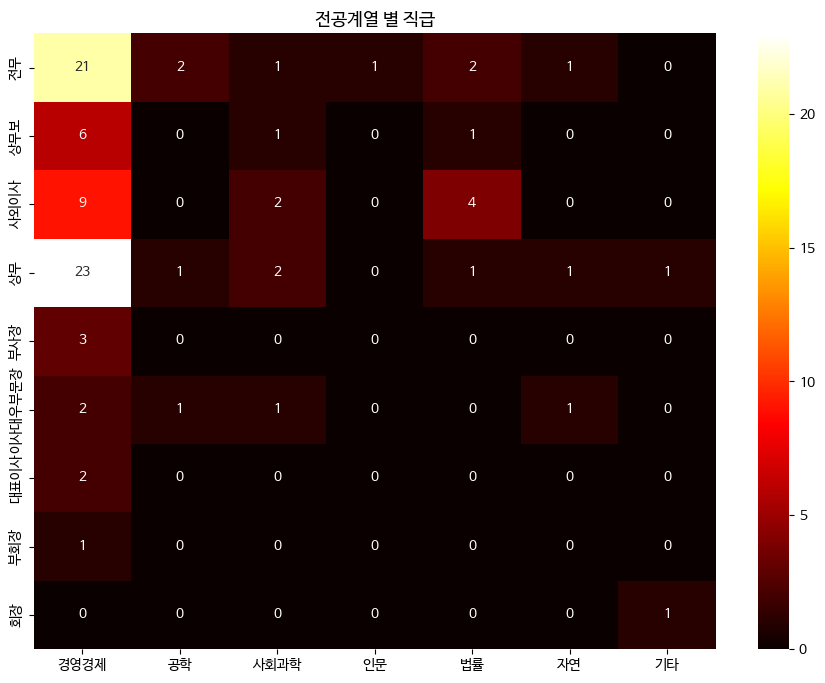

In [523]:
plt.figure(figsize=(11,8))
plt.title('전공계열 별 직급', fontsize=13)
sns.heatmap(data.transpose(), cmap='hot', annot=True, fmt='d')

# 인물 분석

In [ ]:
mmajor_p = ['박규상', '김송규', '조경순', '신인식', '김경식', '배영훈', '박동현', '김범철', '하창룡', '이득원', '진승욱', '이순남', '이재우', '정연우', '문병식', '강윤기', '정연우', '이재우', '김성원', '강준규', '이순남', '김성원', '김성균', '김성균', '김상원', '송종원']
mmajor_p = set(mmajor_p)
mmajor_p = list(mmajor_p)

In [ ]:
df_m = pd.DataFrame()
for i in range(len(mmajor_p)):
  df_m = df_m.append(df[df['이름']==mmajor_p[i]])

In [ ]:
pd.options.display.max_rows = None
df_m.head(100)

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위,대학교,전공,근속연수,주요경력요약
137,진승욱,2018,1968.08,미등기임원,상근,전략지원담당,한양대 경영학\n대신증권 Global사업부장\n대신에프앤아이 경영기획본부 부본부장 ...,0.0,2018.08.16~2018.12.31,2019.03.31,상무,한양대,경영학,0,"{대신에프앤아이, 대신증권}"
162,진승욱,2019,1968.08,미등기임원,상근,전략지원부문장/프라이빗라운지 부문장,한양대 경영학\n대신증권 Global사업부장\n대신에프앤아이 경영기획본부 부본부장/...,203.0,2018.08.16~2019.12.31,2021.03.31,전무,한양대,경영학,1,"{대신에프앤아이, 대신증권}"
201,진승욱,2020,1968.08,미등기임원,상근,경영기획본부장,한양대 경영학\n대신증권 Global사업부장\n대신에프앤아이 경영기획본부 부본부장\...,982.0,2018.08.16~2020.12.31,2022.03.31,전무,한양대,경영학,2,"{대신에프앤아이, 대신증권}"
241,진승욱,2021,1968.08,미등기,상근,경영기획부문장,한양대 경영학\n대신증권 Global사업부장\n대신에프앤아이 경영기획본부 부본부장\...,5034.0,2018.08.16~2021.12.31,2023.03.31,전무,한양대,경영학,3,"{대신에프앤아이, 대신증권}"
15,김경식,2014,1959.12,등기임원,상근,상근감사위원,연세대 경제학(석사)\nSBC WARBURG DILLON READ(현UBS증권) 법...,0.0,2011.05.27~2014.12.31,2015.03.20,감사위원,연세대,경제학,3,"{메릴린치증권, SBC, 푸르덴셜투자증권}"
39,김경식,2015,1959.12,미등기임원,상근,감사담당,연세대 경제학(석사)\nSBC WARBURG DILLON READ(현UBS증권) 법...,0.0,2015.03.20~2015.12.31,2016.03.18,전무,연세대,경제학,0,"{메릴린치증권, SBC, 푸르덴셜투자증권}"
79,김경식,2016,1959.12,미등기임원,상근,-,연세대 경제학(석사)\nSBC WARBURG DILLON READ(현UBS증권) 법...,0.0,2015.03.20~2016.12.31,2017.03.24,전무,연세대,경제학,1,"{메릴린치증권, SBC, 푸르덴셜투자증권, 대신증권}"
23,조경순,2014,1964.01,미등기임원,상근,기획본부장,연세대 경영대학원(석사)\n대신증권 홍보실 이사대우실장\n대신증권 브랜드전략실 이사...,11526.0,2014.01.01~2014.12.31,2015.03.20,상무,연세대,경영대학원,0,{대신증권}
58,조경순,2015,1964.01,미등기임원,상근,기획본부장,연세대 경제학(석사)\n대신증권홍보실 이사대우실장\n대신증권브랜드전략실 이사대우실장,11646.0,2014.01.01~2015.12.31,2016.03.18,상무,연세대,경제학,1,"{대신증권브랜드전략실, 대신증권홍보실}"
90,조경순,2016,1964.01,미등기임원,상근,고객자산본부장 / 홍보담당,연세대 경제학(석사)\n대신증권홍보실 이사대우실장\n대신증권브랜드전략실 이사대우실장...,11636.0,2014.01.01~2016.12.31,2018.03.31,상무,연세대,경제학,2,"{대신증권브랜드전략실, 대신증권홍보실, 대신증권}"


# 가중치 함수

In [ ]:
#학교 거리 계산
def cal_college(df1, df2, alpha = 0.7):
  #지역별로 나눔
  college_dict = {'서울경기':['상명여자사범대', '서울대', '홍익대', '성균관대', '연세대', '연세대학교', '동국대', '중앙대', '한국외대', '한국외국어대', '세종대학교', '세종대', '성균관대학교', '경희대', '서강대', '고려대', '건국대', '가천대', '가천대학교', '한양대', '명지대'],
                   '광역시':['부경대', '경북대', '전남대', '조선대', '한국과학기술원', '가천대', '인하대', '동아대', '대전대', '울산대', '영남공업전문대'],
                   '그외한국':['전북대', '원광대', '충북대', '충북대학교', '강원대', 'KDI'],
                   '해외':['FloridaInternationalUniversity', 'OhioStateUniversity', 'UniversityofBath', '조지아공대', 'Brown대', '카네기멜론대', '미시간대학교']}

  #키값 찾기
  for key, val in college_dict.items() :
    if df1['대학교'] in val :
      df1_key = key
    if df2['대학교'] in val :
      df2_key = key

  #k값 구하기
  if df1['대학교'] == df2['대학교'] :
    k=0
  elif df1_key == df2_key :
    k=1
  elif df1_key != df2_key :
    k=2

  return alpha ** k

#학과 거리 계산
def cal_department(df1, df2, alpha = 0.7):
  department_dict={'경영경제':['회계학', '세무학', '경제학', '국제경영학', '경영학', '무역학', 'MBA', '경제통상학', '경영대학원', '경영대학원MBA', '산업정보학', '금융공학', '국제금융학'],
                   '사회과학':['사회학', '사회과학대학원', '행정학', '정치외교학', '정치학', '신문방송학'],
                   '법률':['법학', '사법학', '정책대학원', '국제정책대학원'],
                   '인문':['불어불문학'],
                   '기타':['교육학', '인적자원개발학'],
                   '자연':['응용통계학', '통계학', '수학'],
                   '공학':['기계공학', '화학공학', '전자계산학', '전자전산학', '전산학', '항공우주학']}

  #키값 찾기
  for key, val in department_dict.items() :
    if df1['전공'] in val :
      df1_key = key
    if df2['전공'] in val :
      df2_key = key

  #k값 구하기
  if df1['전공'] == df2['전공'] :
    k=0
  elif df1_key == df2_key :
    k=1
  elif df1_key != df2_key :
    k=2

  return alpha ** k

#직위 거리 계산
def cal_position(df1, df2, alpha = 0.7):
  position_dict={'회장':0, '대표이사':1, '부회장':2, '사장':3, '부사장':4, '전무':5, '상무': 6, '상무보':7, '이사대우부문장':8, '이사대우담당':8, '사외이사':99, '감사위원':99}

  #value값 찾기
  df1_value = position_dict[df1['직위']]
  df2_value = position_dict[df2['직위']]

  #k값 구하기
  if df1['직위'] == df2['직위'] :
    k=0
  elif df1_value == 99 or df2_value == 99 : #사외이사 혹은 감사인원(회사밖 인물)은 모두와 거리 4(최대차이의 중간값// 회장, 이사대우담당과의 거리)
    k=4
  else :
    k=abs(df1_value - df2_value) #값 차이만큼 거리

  return alpha ** k

# 근속연수 거리 계산
def cal_work_years(df1, df2, alpha = 0.7):
  #k값 구하기
  if df1['근속연수'] == df2['근속연수'] :
    k=0
  else :
    if abs(df1['근속연수'] - df2['근속연수']) % 5 ==0:    #근속연수 차이 5년 기준으로 1씩 증가 (차이 1~5/6~10/11~15/...같은그룹)
      k= abs(df1['근속연수'] - df2['근속연수']) // 5
    else:
      k= 1 + abs(df1['근속연수'] - df2['근속연수']) // 5

  return alpha ** k

#담당업무 거리 계산
def cal_task(df1, df2, alpha = 0.7):
  task_dict={'IT계열': {'IT':['IT부문장', 'IT본부장', 'IT서비스본부장', '디지털부문장', '스마트Biz본부장', 'Operation&Technology본부장'], '정보보호':['정보보호부문장', '정보보호담당']},
             '본사영업':{'Wolesale':['Wholesale부문장','Wholesale영업본부장', 'Wholesale사업단장', 'Trading부문장', 'Trading Center장', 'Sales&Trading총괄', '대외협력담당'],
                     'IB':['IB사업단장', 'IB부문장', 'IB부부문장', 'IB1부문장', 'IB2부문장', 'IPO담당',  'PF부문장', 'PF1본부장', '구조화상품본부장'],
                     '영업':['영업부장']},
             '본사관리':{'리테일':['리테일총괄', 'Club1962센터장','WM추진부문장', 'WM추진본부장', 'WM사업단장'],
                     '리스크':['리스크관리부문장', '리스크관리담당'] ,
                     '경영':['경영전략총괄', '전략지원부문장', '전략지원담당', '경영지원본부장', '경영지원부문장', '경영기획부문장', '경영기획본부장', '기획본부장', '기획본부장 / 투자금융담당', '전략지원부문장/프라이빗라운지 부문장'],
                     '상품':['Product부문장', 'Solution&Product사업단장'],
                     '업무':['업무총괄',  '업무총괄(IB사업단, 고객자산본부 제외)', '업무총괄(IB사업단,고객자산본부 제외)', '업무총괄 (IB사업단,고객자산본부 제외)', '업무총괄(IB사업단, 고객자산본부, 경영지원본부, 정보보호부문, 준법지원부문, 감사부문 제외)'],
                     '금융':['기업금융담당', '스마트금융본부장', '금융주치의추진본부장', '금융주치의사업단장'],
                     '인사,인프라':['인재역량센터장', '인프라관리본부장'],
                     '법률':['준법감시인\n 준법지원부문장', '준법감시인 준법지원부문장', '준법감시인\n준법지원부문장', '준법감시인\n준법지원담당', '준법감시인/준법지원부문장', '준법감시인 / 준법지원담당', 'Advisory본부장'],
                     '감사':['감사위원장', '감사부문장', '감사위원', '상근감사위원', '감사담당'],
                     '언론홍보':['홍보부문장', 'Coverage본부장']},
             '리서치': {'리서치센터':['Research Center장', '리서치센터장', 'Market\n  Solution부문장', 'Research&Strategy본부장', 'Market Solution부문장', 'Market Solution 부문장']},
             '고객':{'고객자산':['고객자산부문장', '고객자산부문 부부문장', '고객자산본부장', '고객자산본부장 / 홍보담당', '고객자산본부장/ 홍보담당', '고객자산본부장/ 홍보부문장', '고객자산본부장/홍보부문장', '고객자산부문장, 홍보부문장', '고객자산부문장\n홍보부문장'],
                   'WM':['서부WM부문장', '서부WM본부장', '재경1WM부문장', '재경1WM본부장', '재경2WM본부장', '재경2WM부문장', '동부WM부문장', '동부WM본부장'],
                   '프라이빗':['프라이빗부문장,\n 나인원프라이빗라운지장', '프라이빗부문장, 나인원프라이빗라운지장', '대신나인원 \n프라이빗라운지장', '프라이빗라운지 부문장 /대신나인원 프라이빗라운지장', '프라이빗부문장, 대신나인원프라이빗라운지장', '프라이빗부문장\n나인원프라이빗라운지장',],
                   '소비자보호':['금융소비자보호부문장\n(COO)', '금융소비자보호부문장(COO)', '금융소비자보호부문장 (COO)', '금융소비자보호 총괄', '금융소비자보호총괄']},
             '기타':{'지점':['강북지역본부장', '강남지역본부장', '강남선릉센터장', '서부지역본부장', '동부지역본부장', '울산지점장'],
                   '비서':['비서실장', '비서/브랜드본부', '비서/브랜드담당'], '공란':['-']}}

   #키값 찾기
  for outerKey in task_dict.keys() :
    for key, val in task_dict[outerKey].items() :
      if df1['담당업무'] in val :
        df1_outerKey = outerKey
        df1_innerKey = key
      if df2['담당업무'] in val :
        df2_outerKey = outerKey
        df2_innerKey = key


  #k값 구하기
  if df1['담당업무'] == df2['담당업무'] : #같은업무
    k=0
  elif df1_outerKey == df2_outerKey and df1_innerKey == df2_innerKey: #상위하위 혹은 비슷한업무
    k=1
  elif df1_outerKey == df2_outerKey : #같은계열업무
    k=2
  elif df1_outerKey != df2_outerKey :
    k=3 #다른계열업무
  return alpha ** k

#경력 거리 계산
def cal_career(df1, df2, alpha = 0.7):
  career_dict={1:['대신증권', '대신증권WM사업단장', 'WM추진부문장', '재경1WM부문장', '대신증권중부지역본부장', '기획본부장대신증권', '대신증권분당지점장', '대신증권무거동지점장', '대신증권Capital',
                  '이사대우부본부장', '기획본부장대신증권인재역량센터장', '대신증권인재전략부', '대신증권파생상품운용부장', '대신증권자산운용본부', '대신증권영업기획부장', '대신증권기획실장',
                  '대신증권홍보실', '대신증권브랜드전략실', '대신증권IT개발부장', '대신증권트레이딩시스템부장', '대신증권Global사업본부', '신증권', '기업금융사업단장'], #대신증권
               0:['대신에프앤아이', '대신투자신탁운용', '대신투자신탁운용상무이사', '대신에이엠씨', '대신자산운용', '대신저축은행'], #대신증권 자회사
               2:['메리츠종금증권', '메리츠증권', '미래에셋증권', 'KTB투자증권', 'SC제일은행', '하나금융투자', 'IBK투자증권', 'DB금융투자', 'NH투자증권', 'KB증권', 'LIG손해보험', '굿모닝신한증권', '메릴린치증권',
                  '삼성증권', '동양증권', '한국투자증권', '한국투자증권평촌지점', '대우증권', '대우본부장', '대우증권전략기획본부', '대우증권해외사업부문', '대우증권IB사업부문',
                  '우리투자증권', '우리CS자산운용', '우리투자증권기업금융2팀장', '우리프라이빗에쿼티', '푸르덴셜투자증권', '하이투자증권주식인수팀',  '하이투자증권주식인수팀', 'SBC', 'Bank', '도이치은행'], #타증권사
               3:['금융감독원', '금융위원회', '現)금융위원회', '감사원', '대검찰청', '법무법인', '現)법무법인', '세무법인', '국세청', '중부지방국세청', '서울북부지방검찰청','서울지방국세청장', '서울지방국세청',
                  '제58대', '제22대', '기획재정부', '국세청,관세청,산업통상자원부', '자본시장연구원', '한국조세연구원', '국가청렴위원회', '대한중재인협회', '한국회계정보학회',
                  '금융위원회금융발전심의위원(현)', '금융위원회적극행정심의위원(現)', '안진회계법인',  'L&C세무회계사무소', '변호사정상명법률사무소', '피앤비세무컨설팅', '現)법무법인(유)'], #법,정책
               4:['중앙대', '중앙대학교', '現)중앙대', '연세대학교', 'KAIST', '수원대', '수원대학교', '서울시립대', '現)서울시립대', '학교법인', '現)학교법인', '재단법인', '現)재단법인'], #학교, 교수, 재단
               5:['하비스트', '한국물산', '우리선물', '부영주택', 'LG경제연구원', 'Arthur'] #기타
               }

  #경력 여부 빈리스트 생성
  df1_list = [0,0,0,0,0,0] #0번인덱스: 대신증권, 1번인덱스: 대신증권 자회사, 2번인덱스: 타증권사, 3번인덱스: 기타
  df2_list = [0,0,0,0,0,0]

  #리스트에 각 업종에 종사했었으면 1, 아니면 0
  for career in df1['주요경력요약'] :
    for key, val in career_dict.items() :
      if career in val :
        df1_list[key]=1

  for career in df2['주요경력요약'] :
    for key, val in career_dict.items() :
      if career in val :
        df2_list[key]=1

  #df1_list 와 df2_list 합 구하기(요소가 0-> 둘다 종사 안했음, 1-> 한쪽만 종사함, 2-> 둘다 종사함)
  sum_list = [x + y for x, y in zip(df1_list, df2_list)]

  #k값 구하기
  if df1_list == df2_list : #전체 같으면 0
    k=0

  elif (sum_list[0]==0 and sum_list[1]==0 and sum_list[2]==0): #기타만 있을 때 (법률, 학교, 기타)
    count2 = sum_list.count(2) #2인 요소 개수 찾기(df1, df2 같은거 개수)
    k = 0.6 * (1 + count2)

  else : #기타만 있는거 아니고,
    #법률, 학교, 기타 전부 기타로 통합. 범주는 3으로.
    if sum(df1_list[3:]) > 0 :
      df1_list[3] = 1
      df1_list[4] = 0
      df1_list[5] = 0
    if sum(df2_list[3:]) > 0 :
      df2_list[3] = 1
      df2_list[4] = 0
      df2_list[5] = 0

    #수정한 df1_list, df2_list로 sum_list 다시 생성
    sum_list = [x + y for x, y in zip(df1_list, df2_list)]

    #df1_list, df2_list에서 1인 인덱스 뽑기
    index1 = [i for i in range(len(df1_list)) if df1_list[i] == 1]
    index2 = [i for i in range(len(df2_list)) if df2_list[i] == 1]

    min = 10
    max = 0

    for i in index1 :
      for j in index2 :
        if i != j: #두 사람 간에, 다른 업종끼리 최대거리 최소 거리 구하기

          if (i==3 and j != 3) or (j==3 and i != 3) : #기타와 다른 업종
            max = 4 #기타는 모두와 거리 4 고정 (최대거리 구하기)
            temp = 4
          else : #최대거리 구하기
            temp = abs(i-j)
            if temp > max:
              max = temp
          if temp < min: #최소거리 구하기
            min = temp

    k=float((max+min)/2) #거리는 최대거리, 최소거리의 평균
    k= k- (0.5 * sum_list.count(2)) # 같은 업종 있으면, 있는 만큼 거리 -0.5

  return alpha ** k

#보유 주식수별 거리 계산
def cal_stock(df1, df2, alpha = 0.7):
  #k값 구하기
  if df1['의결권 있는 주식수'] == df2['의결권 있는 주식수'] :
    k=0
  else :
    k= abs(df1['의결권 있는 주식수'] - df2['의결권 있는 주식수'])//100 #차이로 보기=> 차이가 거리가 됨(너무 차이 크면 거리 멀어짐), 100개 단위로 끊어서 보기
    k=math.log10(1+k) #로그스케일
  return alpha ** k

In [ ]:
#가중치 함수
def weight_sum(df1, df2):
  wt_college = cal_college(df1, df2)
  wt_department = cal_department(df1, df2)
  wt_position = cal_position(df1, df2)
  wt_task = cal_task(df1, df2)
  wt_work_years = cal_work_years(df1, df2)
  wt_career = cal_career(df1, df2)
  wt_stock = cal_stock(df1, df2)
  return wt_college + wt_department + wt_position + wt_task + wt_work_years + wt_career + wt_stock

In [ ]:
# 인물 가중치행렬
col = []
row = []
matrixs = []
dataFrames = [df_2014, df_2015, df_2016, df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023]

for dataframe in dataFrames:
  for i in range(len(dataframe)):
      col.append(dataframe.loc[i, '이름'])
      row.append(dataframe.loc[i, '이름'])
  weight_matrix = pd.DataFrame(columns=col, index=row)
  matrixs.append(weight_matrix)
  col=[]
  row=[]

In [ ]:
#가중치 계산
for t, dataframe in enumerate(dataFrames):
  for i in range(0, len(dataframe)):
    for j in range(0, len(dataframe)):
      matrixs[t].iloc[i, j] = round(weight_sum(dataframe.iloc[i], dataframe.iloc[j])**2, 2)

In [ ]:
matrixs[0]

,이현식,조윤남,나재철,이정훈,송혁,하창룡,이동훈,박동현,홍대한,박찬수,...,이어룡,양홍석,김봉규,조경순,김병철,김창봉,박찬욱,배영훈,이인형,장우철
이현식,49.0,17.6,17.79,13.76,24.15,23.64,16.75,24.15,21.62,14.36,...,12.88,20.87,24.71,21.73,22.39,12.06,15.36,26.64,10.64,23.85
조윤남,17.6,49.0,12.33,8.72,17.98,20.43,21.31,20.32,20.92,9.75,...,10.13,11.57,19.58,20.75,20.25,8.72,8.72,20.09,10.58,25.14
나재철,17.79,12.33,49.0,8.6,13.94,13.33,11.37,13.28,16.27,10.97,...,20.11,21.4,15.19,16.21,15.72,10.82,11.85,18.22,9.48,15.54
이정훈,13.76,8.72,8.6,49.0,11.81,11.31,8.23,15.13,10.14,26.8,...,11.63,10.32,9.99,10.19,10.11,23.86,34.13,9.74,21.85,9.18
송혁,24.15,17.98,13.94,11.81,49.0,20.2,16.8,19.73,20.65,12.37,...,11.42,14.13,19.95,21.28,21.2,10.24,13.3,21.77,10.24,20.19
하창룡,23.64,20.43,13.33,11.31,20.2,49.0,19.33,30.7,22.92,14.7,...,12.52,11.57,26.21,23.21,18.18,12.37,11.31,19.01,9.04,21.59
이동훈,16.75,21.31,11.37,8.23,16.8,19.33,49.0,19.31,22.1,9.23,...,10.14,10.19,16.77,22.09,16.82,8.23,8.23,18.28,9.48,20.62
박동현,24.15,20.32,13.28,15.13,19.73,30.7,19.31,49.0,22.68,17.22,...,12.52,11.57,25.81,22.87,17.99,12.48,11.43,18.98,9.14,23.06
홍대한,21.62,20.92,16.27,10.14,20.65,22.92,22.1,22.68,49.0,12.71,...,11.5,14.13,20.03,30.94,19.66,12.54,11.52,21.01,13.19,22.62
박찬수,14.36,9.75,10.97,26.8,12.37,14.7,9.23,17.22,12.71,49.0,...,12.82,9.5,14.75,14.99,9.86,25.3,29.02,12.26,20.43,11.62
